In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics 
import sys 
!{sys.executable} -m pip install heartpy
import heartpy as hp
from sklearn import preprocessing
from heartpy.filtering import filter_signal

In [2]:
RawData1 = sio.loadmat( 'C:/4th_2endSemester/MLBRLab/BPEstimation/data/Part_1.mat' )

In [3]:
RearrangedData = { 'SamplingRate':125.0 , 'ppg' : [] , 'diff1ppg' : [] , 'diff2ppg' : [] , 'abp' : [] }

In [4]:
def GetPPG():
    for i in range( len(RawData1['Part_1'][0][0:20]) ):
        #Low pass filter
        N = len(RawData1['Part_1'][0][i][0])
        t = np.linspace( 0 , N , N )
        F = t*RearrangedData['SamplingRate']/N - RearrangedData['SamplingRate']/2
        yf = np.fft.fft( RawData1['Part_1'][0][i][0] )
        yf = np.fft.fftshift( yf )
        for i in range( N ):
            if ( F[i] > 10 ) | ( F[i] < -10 ):
                yf[i] = 0
        iyf = np.abs( np.fft.ifft( yf ) )

        #Nomarlization
        iyf = ( iyf - np.min(iyf) ) / ( max(iyf) - min(iyf) )
        RearrangedData['ppg'].append( iyf )

    #RearrangedData['ppg'] = np.array( RearrangedData['ppg'] )
    return
def GetabpRawData():
    for i in range( len(RawData1['Part_1'][0][0:20]) ):
        RearrangedData['abp'].append( RawData1['Part_1'][0][i][1] )
    return

def GetPPG_Diff():
    for i in range( len(RearrangedData['ppg']) ):
        diff1 = []
        diff2 = []
        #Get and Filter 1st derivative ppg
        for j in range( 1 , len(RearrangedData['ppg'][i]) , 1 ):
            diff1.append( RearrangedData['ppg'][i][j] - RearrangedData['ppg'][i][j-1] )
        #diff1 = filter_signal( diff1 , cutoff = [ 0.5 , 4 ] , sample_rate = 125.0 , order = 4 , filtertype = 'bandpass' )

        for k in range( 1 , len(diff1) , 1 ):
            diff2.append( diff1[k] - diff1[k-1] )
        #diff2 = filter_signal( diff2 , cutoff = [ 0.5 , 4 ] , sample_rate = 125.0 , order = 4 , filtertype = 'bandpass' )
        RearrangedData['diff1ppg'].append( diff1 )
        RearrangedData['diff2ppg'].append( diff2 )
            


    return

GetPPG()
GetabpRawData()
GetPPG_Diff()

In [5]:
AttributeTable = { 'systolicIndex': [] , 'systolicValue': [] , 'hr': [] , 'valleyIndex0': [] , 'valleyValue0':[] , 'maxSlopeIndex': [] , 'maxSlopeValue': [] , 'minSlopeIndex' : [] , 'minSlopeValue' : [] , 'peakValue1st': [] , 'valleyValue1st' : [] ,  'DicroticIndex': [] , 'DicroticValue':[] }

In [6]:
def get_peakIndex_and_peakValue_ofppg( startIndex , endIndex ):
    for i in range( startIndex , endIndex , 1 ):
        #get peak index of ppg
        #temp = []
        working_data, measures = hp.process(RearrangedData['ppg'][i], 125.0)
        AttributeTable['systolicIndex'].append( np.setdiff1d( working_data['peaklist'] , working_data['removed_beats'] ) )
        temp = []
        for j in range( len(AttributeTable['systolicIndex'][i]) ):
            temp.append( RearrangedData['ppg'][i][AttributeTable['systolicIndex'][i][j]] ) 
        temp = np.array( temp )
        AttributeTable['systolicValue'].append(temp)
    return
get_peakIndex_and_peakValue_ofppg(0, 20)

In [7]:
def Get_ValleyandHr():
    for x in range( len(AttributeTable['systolicIndex']) ):

        #Find the valleyIndex0 and valleyValue0
        minIndex = []
        minList = []
        for i in range( 1 , len(AttributeTable['systolicIndex'][x]) , 1 ):
            tempIndex = 0
            tempMin = 3
            for j in range( AttributeTable['systolicIndex'][x][i-1] ,  AttributeTable['systolicIndex'][x][i] , 1 ):
                if RearrangedData['ppg'][x][j] < tempMin:
                    tempIndex = j
                    tempMin = RearrangedData['ppg'][x][j]
            minIndex.append( tempIndex )
            minList.append( tempMin )
        minIndex = np.array( minIndex )
        minList = np.array( minList )
        AttributeTable['valleyIndex0'].append( minIndex )
        AttributeTable['valleyValue0'].append( minList )

        #Get hr 
        temphr = []
        for i in range( 1 , len( AttributeTable['valleyIndex0'][x] ) , 1 ):
            temphr.append( 60*125 / ( AttributeTable['valleyIndex0'][x][i] - AttributeTable['valleyIndex0'][x][i-1] ) )
        temphr = np.array( temphr )
        AttributeTable['hr'].append( temphr )    

    return

Get_ValleyandHr()

In [8]:
def Get_MaxSlopeandDicroticNotch():
    for x in range( len(AttributeTable['valleyIndex0']) ):
        maxSlopeIndexList = []
        maxSlopeValueList = []
        minSlopeIndexList = []
        minSlopeValueList = []
        peakValue1stList = []
        valleyValue1stList = []
        DicroticIndexList = []
        DicroticValueList = []
        for i in range( 1 , len( AttributeTable['valleyIndex0'][x] ) , 1 ):
            maxSlope = -100
            maxSlopeIndex = 0
            minSlope = 100
            minSlopeIndex = 0
            for j in range( AttributeTable['valleyIndex0'][x][i-1] , AttributeTable['valleyIndex0'][x][i] , 1 ):
                if RearrangedData['diff1ppg'][x][j] > maxSlope:
                    maxSlope = RearrangedData['diff1ppg'][x][j]
                    maxSlopeIndex = j 
            for j in range( AttributeTable['systolicIndex'][x][i] , int((AttributeTable['valleyIndex0'][x][i] + AttributeTable['systolicIndex'][x][i])/2) , 1 ):
                if RearrangedData['diff1ppg'][x][j] < minSlope:
                    minSlope = RearrangedData['diff1ppg'][x][j]
                    minSlopeIndex = j 
            maxSlopeIndexList.append( maxSlopeIndex )
            maxSlopeValueList.append( RearrangedData['ppg'][x][maxSlopeIndex] )
            minSlopeIndexList.append( minSlopeIndex )
            minSlopeValueList.append( RearrangedData['ppg'][x][minSlopeIndex] )
            peakValue1stList.append( maxSlope )
            valleyValue1stList.append( minSlope )


            maxdiff2 = -100
            maxdiff2Index = 0
            for k in range( minSlopeIndexList[i-1] , AttributeTable['valleyIndex0'][x][i] , 1 ):
                if RearrangedData['diff2ppg'][x][k-5] > maxdiff2:
                    maxdiff2 = RearrangedData['diff2ppg'][x][k-5]
                    maxdiff2Index = k 
            DicroticIndexList.append( maxdiff2Index )
            DicroticValueList.append( RearrangedData['ppg'][x][maxdiff2Index] )

                



        maxSlopeIndexList = np.array( maxSlopeIndexList )
        maxSlopeValueList = np.array( maxSlopeValueList )
        minSlopeIndexList = np.array( minSlopeIndexList )
        minSlopeValueList = np.array( minSlopeValueList )
        peakValue1stList = np.array( peakValue1stList )
        valleyValue1stList = np.array( valleyValue1stList )
        DicroticIndexList = np.array( DicroticIndexList )
        DicroticValueList = np.array( DicroticValueList )

        AttributeTable['maxSlopeIndex'].append( maxSlopeIndexList )
        AttributeTable['maxSlopeValue'].append( maxSlopeValueList )
        AttributeTable['minSlopeIndex'].append( minSlopeIndexList )
        AttributeTable['minSlopeValue'].append( minSlopeValueList )
        AttributeTable['peakValue1st'].append( peakValue1stList )
        AttributeTable['valleyValue1st'].append( valleyValue1stList )
        AttributeTable['DicroticIndex'].append( DicroticIndexList )
        AttributeTable['DicroticValue'].append( DicroticValueList )

        
    return

Get_MaxSlopeandDicroticNotch()

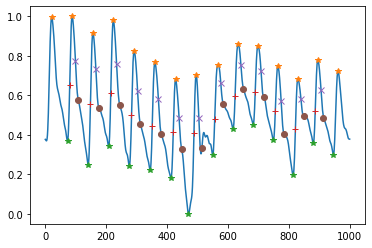

In [9]:
y = 13
Test = RearrangedData['ppg'][y]
t = np.linspace( 0 , len(Test) , len(Test) )

plt.plot( t , Test )
plt.plot( AttributeTable['systolicIndex'][y] , AttributeTable['systolicValue'][y]  , '*')
plt.plot( AttributeTable['valleyIndex0'][y] , AttributeTable['valleyValue0'][y]  , '*')
plt.plot( AttributeTable['maxSlopeIndex'][y] , AttributeTable['maxSlopeValue'][y] , '+' )
plt.plot( AttributeTable['minSlopeIndex'][y] , AttributeTable['minSlopeValue'][y] , 'x' )
plt.plot( AttributeTable['DicroticIndex'][y] , AttributeTable['DicroticValue'][y] , 'o' )